In [5]:
import os
print(os.getcwd())
print(os.path.exists("./resource/dataset/Porto/porto_sample.csv"))

/home/hetianran/trajectory/TrajMM
True


In [6]:
import transbigdata as tbd
import pandas as pd
# 地图匹配包
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching import visualization as mmviz
 
#读取数据
data = pd.read_csv("./resource/dataset/Porto/porto_sample.csv",on_bad_lines='warn')
data = data.head(5)
data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [7]:
import pandas as pd
import json

# 假设 sample_data 是从 DataFrame 中提取的一行数据
sample_data = data.iloc[0]

# 1. 解析 POLYLINE 字段，获取经纬度列表
gps_loc_list = json.loads(sample_data['POLYLINE'])  # 解析为坐标点列表，格式通常是[[lng, lat], [lng, lat], ...]

# 2. 生成时间戳列表
timestamp_list = [sample_data['TIMESTAMP'] + 15 * i for i in range(len(gps_loc_list))]  # 每个时间戳间隔15
datetime_list = pd.to_datetime(timestamp_list, unit='s')  # 转换为 datetime 对象

# 3. 生成 ID 列
id_list = [sample_data["TRIP_ID"] for _ in range(len(gps_loc_list))]  # 所有坐标点的 TRIP_ID 相同

# 4. 提取经纬度
lng_list = [loc[0] for loc in gps_loc_list]  # 获取每个坐标点的经度
lat_list = [loc[1] for loc in gps_loc_list]  # 获取每个坐标点的纬度

# 5. 创建 DataFrame
sample_traj_df = pd.DataFrame({
    'ID': id_list,
    'Time': datetime_list,
    'Lng': lng_list,
    'Lat': lat_list
})

sample_traj_df


,ID,Time,Lng,Lat
0,1372636858620000589,2013-07-01 00:00:58,-8.618643,41.141412
1,1372636858620000589,2013-07-01 00:01:13,-8.618499,41.141376
2,1372636858620000589,2013-07-01 00:01:28,-8.620326,41.142510
3,1372636858620000589,2013-07-01 00:01:43,-8.622153,41.143815
4,1372636858620000589,2013-07-01 00:01:58,-8.623953,41.144373
5,1372636858620000589,2013-07-01 00:02:13,-8.626680,41.144778
6,1372636858620000589,2013-07-01 00:02:28,-8.627373,41.144697
7,1372636858620000589,2013-07-01 00:02:43,-8.630226,41.145210
8,1372636858620000589,2013-07-01 00:02:58,-8.632746,41.146920
9,1372636858620000589,2013-07-01 00:03:13,-8.631738,41.148225


In [11]:
# 获取路网
import osmnx as ox

ox.settings.cache_folder = "./resource/cache"

bounds = [-8.69173, 41.13898, -8.56436, 41.18589]
G = ox.graph_from_bbox(bounds, network_type="drive")
ox.save_graphml(G, "./resource/cache/porto.graphml")

# 获取道路中心点坐标
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
edges["lon"] = edges.centroid.x
edges["lat"] = edges.centroid.y

# 转换路网的坐标系
G_p = ox.project_graph(G, to_crs=2416)
nodes_p, edges_p = ox.graph_to_gdfs(G_p, nodes=True, edges=True)

/tmp/ipykernel_38183/1731192854.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges["lon"] = edges.centroid.x
/tmp/ipykernel_38183/1731192854.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges["lat"] = edges.centroid.y


<Axes: >

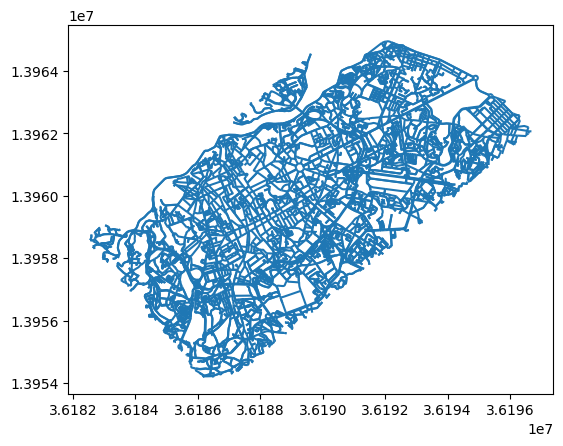

In [12]:
edges_p.plot()

In [13]:
# 将路网转换为网络
map_con = InMemMap(name='pNEUMA', use_latlon=False) # , use_rtree=True, index_edges=True)
 
# 构建网络
for node_id, row in nodes_p.iterrows():
    map_con.add_node(node_id, (row['y'], row['x']))
for node_id_1, node_id_2, _ in G_p.edges:
    map_con.add_edge(node_id_1, node_id_2)

list(map_con.all_edges())[1]

(25503936,
 (13960800.650922153, 36190899.67124633),
 281726624,
 (13960584.291706963, 36191055.34759748))

In [ ]:
# 用transbigdata提取出行轨迹
import geopandas as gpd

tmp_gdf = sample_traj_df
# 轨迹增密
# tmp_gdf = tbd.traj_densify(tmp_gdf,col = ['ID', 'Time', 'Lng', 'Lat'],timegap = 15)
# 转换轨迹的坐标系为地理坐标系
tmp_gdf["geometry"] = gpd.points_from_xy(tmp_gdf["Lng"], tmp_gdf["Lat"])
tmp_gdf = gpd.GeoDataFrame(tmp_gdf)
tmp_gdf.crs = {"init": "epsg:4326"}
tmp_gdf = tmp_gdf.to_crs(2416)
# 获得轨迹点
path = list(zip(tmp_gdf.geometry.y, tmp_gdf.geometry.x))
# 构建地图匹配工具
matcher = DistanceMatcher(
    map_con,
    max_dist=500,
    max_dist_init=170,
    min_prob_norm=0.0001,
    non_emitting_length_factor=0.95,
    obs_noise=50,
    obs_noise_ne=50,
    dist_noise=50,
    max_lattice_width=20,
    non_emitting_states=True,
)
# 进行地图匹配
states, _ = matcher.match(path, unique=False)
# 绘制底图匹配结果
mmviz.plot_map(
    map_con,
    matcher=matcher,
    show_labels=False,
    show_matching=True,  # show_graph=True,
    filename=None,
    figwidth=5
)

In [ ]:
matcher.path_pred

In [ ]:
# 获取地图匹配的路径geodataframe
pathdf = pd.DataFrame(matcher.path_pred_onlynodes, columns=["u"])
pathdf["v"] = pathdf["u"].shift(-1)
pathdf = pathdf[-pathdf["v"].isnull()]
pathgdf = pd.merge(pathdf, edges_p.reset_index())
pathgdf = gpd.GeoDataFrame(pathgdf)
pathgdf.plot()
pathgdf.crs = {"init": "epsg:2416"}
pathgdf_4326 = pathgdf.to_crs(4326)

In [ ]:
# 与路网一起可视化
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(1, (8, 8), dpi=100)
ax = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect=(0.05, 0.1, 1, 0.9))
# 设定可视化边界
bounds = pathgdf_4326.unary_union.bounds
gap = 0.003
bounds = [bounds[0] - gap, bounds[1] - gap, bounds[2] + gap, bounds[3] + gap]
# 绘制匹配的路径
pathgdf_4326.plot(ax=ax, zorder=1)
# 绘制底图路网
tbd.clean_outofbounds(edges, bounds, col=["lon", "lat"]).plot(
    ax=ax, color="#333", lw=0.1
)
# 绘制GPS点
tmp_gdf.to_crs(4326).plot(ax=ax, color="r", markersize=5, zorder=2)

plt.axis("off")
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.show()